In [1]:
!pip install torchvision
!pip install scipy numpy matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform for Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26421880/26421880 [00:02<00:00, 11826851.71it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271060.34it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5129557.90it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12096513.72it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=20, beta=10.0):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),   # (8,14,14)
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=6, stride=2, padding=2),  # (16,7,7)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0), # (32,3,3)
            nn.ReLU(),
            nn.Flatten(),  # (32*3*3)=288
            nn.Linear(288, 128)
        )
        
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.Linear(128, 128),
            nn.Linear(128, 288)
        )
        
        self.dec_conv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0),  # Output: (16, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (8, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
        
    def encode(self, x):  
        h = self.enc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h = self.dec_fc(z)
        h = h.view(-1, 32, 3, 3)
        x_recon = self.dec_conv(h)
        return x_recon
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
    def loss_function(self, x, x_recon, mu, logvar):
        recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + self.beta * kl_loss
        return loss, recon_loss, kl_loss


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BetaVAE(latent_dim=10, beta=4.0).to(device)  # adjust beta as desired

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model)
# model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50

model.train()
for epoch in range(epochs):
    train_loss = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x)
        loss, recon_loss, kl_loss = model.loss_function(x, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader.dataset):.4f}")


Epoch 1/50, Loss: 334.7356
Epoch 2/50, Loss: 281.1945
Epoch 3/50, Loss: 277.3242
Epoch 4/50, Loss: 275.8634
Epoch 5/50, Loss: 274.8304
Epoch 6/50, Loss: 274.0543
Epoch 7/50, Loss: 273.6632
Epoch 8/50, Loss: 273.3519
Epoch 9/50, Loss: 273.0436
Epoch 10/50, Loss: 272.7229
Epoch 11/50, Loss: 272.4962
Epoch 12/50, Loss: 272.2629
Epoch 13/50, Loss: 271.9882
Epoch 14/50, Loss: 271.9354
Epoch 15/50, Loss: 271.8366
Epoch 16/50, Loss: 271.6384
Epoch 17/50, Loss: 271.6456
Epoch 18/50, Loss: 271.4782
Epoch 19/50, Loss: 271.3777
Epoch 20/50, Loss: 271.2945
Epoch 21/50, Loss: 271.0659
Epoch 22/50, Loss: 271.1505
Epoch 23/50, Loss: 270.9700
Epoch 24/50, Loss: 271.0416
Epoch 25/50, Loss: 271.0362
Epoch 26/50, Loss: 270.8997
Epoch 27/50, Loss: 270.8244
Epoch 28/50, Loss: 270.8037
Epoch 29/50, Loss: 270.6474
Epoch 30/50, Loss: 270.7113
Epoch 31/50, Loss: 270.5811
Epoch 32/50, Loss: 270.5036
Epoch 33/50, Loss: 270.5651
Epoch 34/50, Loss: 270.4783
Epoch 35/50, Loss: 270.3433
Epoch 36/50, Loss: 270.4292
E

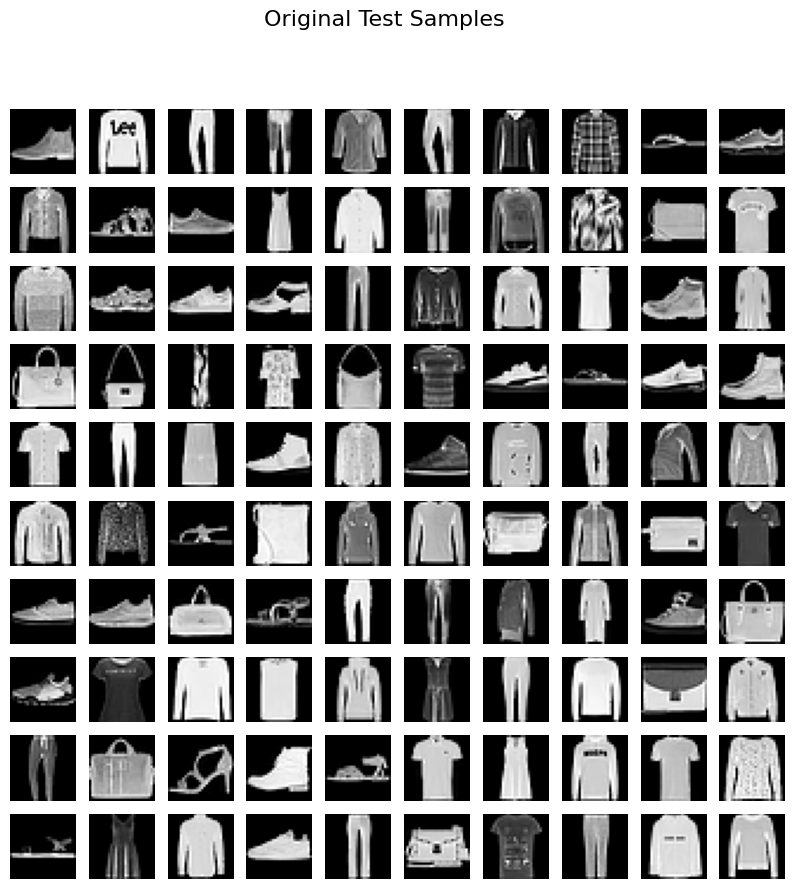

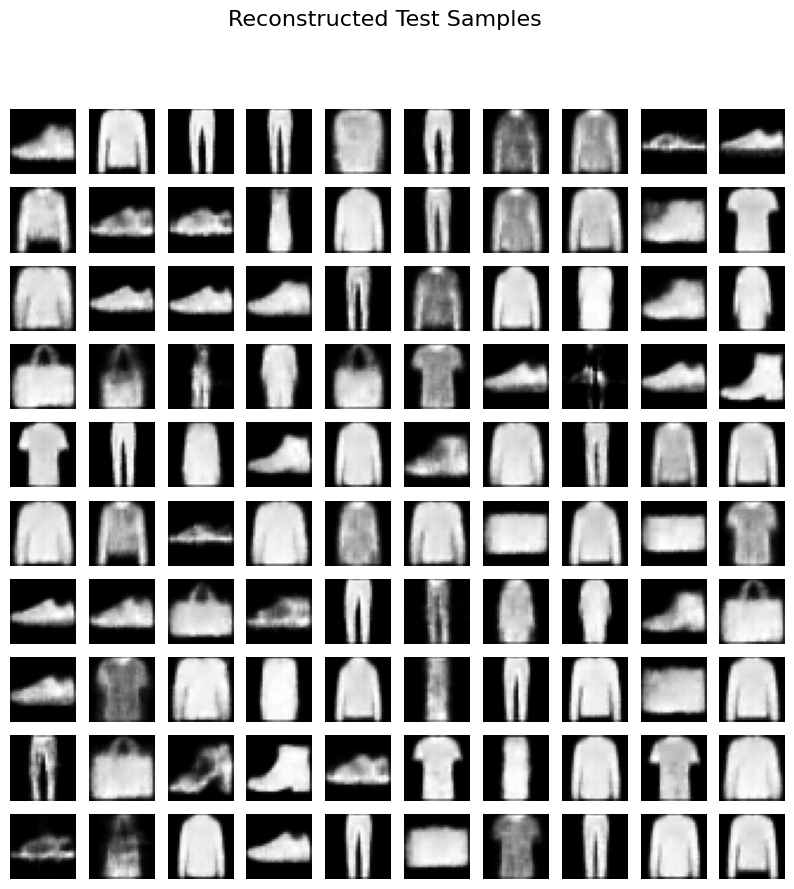

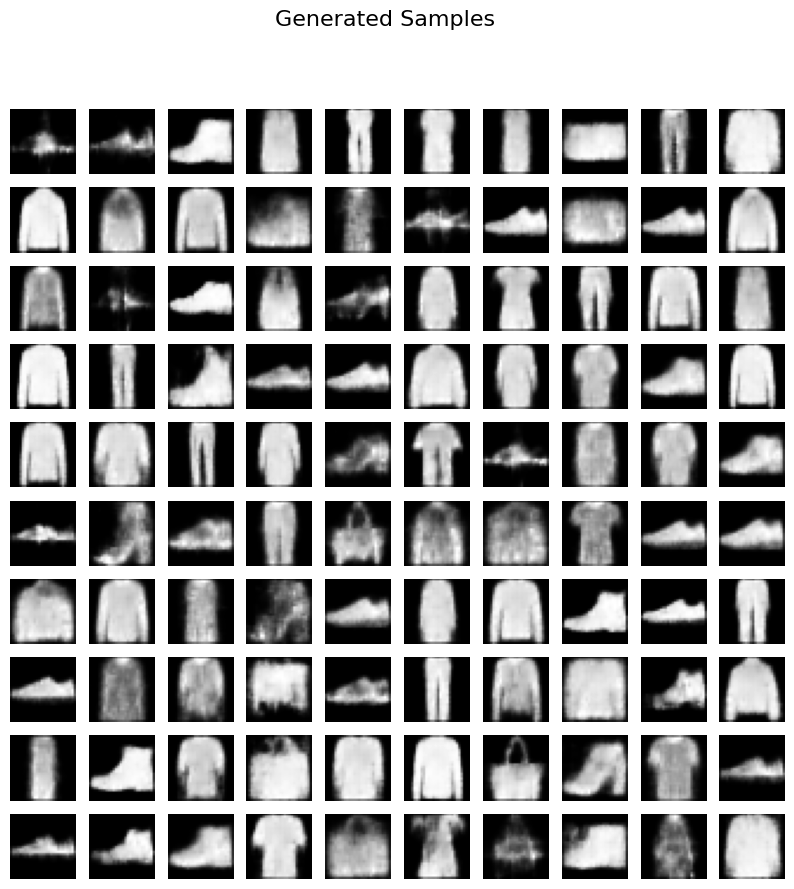

In [7]:
import matplotlib.pyplot as plt

model.eval()

# Get 100 test samples
test_samples, _ = next(iter(test_loader))
test_samples = test_samples[:100].to(device)

# Reconstruct
with torch.no_grad():
    x_recon, _, _ = model(test_samples)

# Convert to CPU and numpy for visualization
test_samples_np = test_samples.cpu().numpy()
recon_samples_np = x_recon.cpu().numpy()

# Display original vs reconstructed
fig, axes = plt.subplots(10, 10, figsize=(10,10))
axes = axes.flatten()
for i in range(100):
    axes[i].imshow(test_samples_np[i,0], cmap='gray')
    axes[i].axis('off')
fig.suptitle("Original Test Samples", fontsize=16)
plt.show()

fig, axes = plt.subplots(10, 10, figsize=(10,10))
axes = axes.flatten()
for i in range(100):
    axes[i].imshow(recon_samples_np[i,0], cmap='gray')
    axes[i].axis('off')
fig.suptitle("Reconstructed Test Samples", fontsize=16)
plt.show()

# Generate 100 random samples
z = torch.randn(100, model.latent_dim).to(device)
with torch.no_grad():
    gen_samples = model.decode(z)
gen_samples_np = gen_samples.cpu().numpy()

fig, axes = plt.subplots(10, 10, figsize=(10,10))
axes = axes.flatten()
for i in range(100):
    axes[i].imshow(gen_samples_np[i,0], cmap='gray')
    axes[i].axis('off')
fig.suptitle("Generated Samples", fontsize=16)
plt.show()


In [8]:
import torch
from torchvision import transforms, datasets
from torchvision.models import inception_v3
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
vae_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Keep original size for the VAE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale data
])

inception_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel RGB
    transforms.Resize((299, 299)),               # Resize to 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB data
])

# Datasets
vae_dataset = datasets.FashionMNIST(root='./data', train=False, transform=vae_transform, download=True)
inception_dataset = datasets.FashionMNIST(root='./data', train=False, transform=inception_transform, download=True)

# DataLoaders
vae_loader = DataLoader(vae_dataset, batch_size=64, shuffle=False)
inception_loader = DataLoader(inception_dataset, batch_size=64, shuffle=False)

# Define your VAE model
vae_model = model
vae_model.eval()

# Load Inception-V3 for feature extraction
inception = inception_v3(pretrained=True, transform_input=False).to(device)
inception.eval()

# Wrap Inception for feature extraction
class WrapInception(nn.Module):
    def __init__(self, inception):
        super(WrapInception, self).__init__()
        self.inception = inception

    def forward(self, x):
        x = (x - 0.5) * 2  # Normalize to [-1, 1]
        return self.inception(x)

feature_extractor = WrapInception(inception).to(device)

# Example: Pass grayscale data to the VAE
vae_batch, _ = next(iter(vae_loader))
vae_batch = vae_batch.to(device)

with torch.no_grad():
    recon_batch, _, _ = vae_model(vae_batch)  # VAE expects 1-channel input

# Example: Pass RGB data to Inception-V3
inception_batch, _ = next(iter(inception_loader))
inception_batch = inception_batch.to(device)

with torch.no_grad():
    features = feature_extractor(inception_batch)  # Inception expects 3-channel input


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 188MB/s]  


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


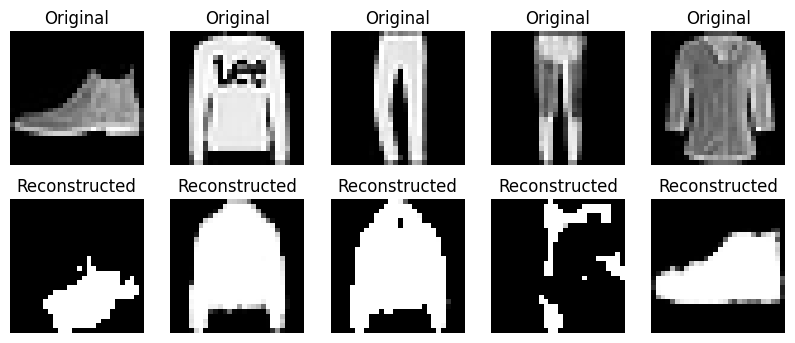

FID (Test vs Reconstructed): 843.9853603120479
FID (Test vs Generated): 629.2479267948074


In [9]:
import torch
from torchvision import transforms, datasets
from torchvision.models import inception_v3
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations for test dataset to feed into Inception
inception_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel RGB
    transforms.Resize((299, 299)),               # Resize to 299x299 for Inception
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize from [0,1] to [-1,1]
])

# Transformations for the VAE input (28x28 grayscale)
vae_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Grayscale normalization
])

# Datasets
vae_dataset = datasets.FashionMNIST(root='./data', train=False, transform=vae_transform, download=True)
inception_dataset = datasets.FashionMNIST(root='./data', train=False, transform=inception_transform, download=True)

# DataLoaders
vae_loader = DataLoader(vae_dataset, batch_size=64, shuffle=False)
inception_loader = DataLoader(inception_dataset, batch_size=64, shuffle=False)

# This is our VAE model
vae_model = model  
vae_model.eval()

# Load Inception-V3 for feature extraction
inception = inception_v3(pretrained=True, transform_input=False).to(device)
inception.eval()

# Wrap Inception for feature extraction
class WrapInception(nn.Module):
    def __init__(self, inception):
        super(WrapInception, self).__init__()
        self.inception = inception

    def forward(self, x):
        # Inception expects inputs roughly in range [-1, 1], but we will already ensure that
        # our inputs match this range outside this class.
        return self.inception(x)

feature_extractor = WrapInception(inception).to(device)

# Function to compute dataset statistics
def get_dataset_stats(loader, model, device):
    feats = []
    with torch.no_grad():
        for batch in loader:
            img = batch[0].to(device)
            f = model(img)
            feats.append(f.cpu().numpy())
    feats = np.concatenate(feats, axis=0)
    mu = np.mean(feats, axis=0)
    sigma = np.cov(feats, rowvar=False)
    return mu, sigma

# Function to compute FID
def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Compute VAE Reconstructions
vae_batch, _ = next(iter(vae_loader))
vae_batch = vae_batch.to(device)

with torch.no_grad():
    # As our VAE's forward returns recon_batch, mu, logvar or something similar
    recon_batch, _, _ = vae_model(vae_batch)  # Reconstructed images (N,1,28,28)

# Display some original and reconstructed images
def show_images(original, reconstructed, n=5):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        # Original
        axes[0, i].imshow(original[i].squeeze(0).cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Reconstructed
        axes[1, i].imshow(reconstructed[i].squeeze(0).cpu().numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")
    plt.show()

show_images(vae_batch, recon_batch)

# Convert reconstructed images from (N,1,28,28) to (N,3,299,299) and normalize
recon_batch_3ch = recon_batch.repeat(1, 3, 1, 1)  # (N,3,28,28)
recon_batch_3ch = torch.nn.functional.interpolate(recon_batch_3ch, size=(299, 299), mode='bilinear', align_corners=False)
# Normalize from [0,1]-like to [-1,1]: If vae output is scaled in [0,1], first we ensure that:
# If VAE outputs in [-1,1], adjust the normalization accordingly. As VAE outputs in [-1,1],
# In that case, if already [-1,1], we might not need further normalization. If it's in [0,1], we do this:
# Usually, after vae_transform and inverse, we might get values in [-1,1]. Check our VAE output range.
# If VAE outputs are in [-1,1], we skip re-normalization. If in [0,1], we use the line below:
# recon_batch_3ch = (recon_batch_3ch - 0.5) / 0.5


recon_dataset = TensorDataset(recon_batch_3ch.cpu())
recon_loader = DataLoader(recon_dataset, batch_size=64, shuffle=False)

test_mu, test_sigma = get_dataset_stats(inception_loader, feature_extractor, device)
recon_mu, recon_sigma = get_dataset_stats(recon_loader, feature_extractor, device)

fid_recon = calculate_fid(test_mu, test_sigma, recon_mu, recon_sigma)
print(f"FID (Test vs Reconstructed): {fid_recon}")

# Compute FID for Generated Samples
z = torch.randn(1000, vae_model.latent_dim, device=device)
with torch.no_grad():
    gen_images = vae_model.decode(z)  # Generated images (N,1,H,W), in [-1,1] range

# Convert generated images to 3-channels and resize
gen_images_3ch = gen_images.repeat(1, 3, 1, 1)  # (N,3,H,W)
gen_images_3ch = torch.nn.functional.interpolate(gen_images_3ch, size=(299, 299), mode='bilinear', align_corners=False)

gen_dataset = TensorDataset(gen_images_3ch.cpu())
gen_loader = DataLoader(gen_dataset, batch_size=64, shuffle=False)

gen_mu, gen_sigma = get_dataset_stats(gen_loader, feature_extractor, device)
fid_gen = calculate_fid(test_mu, test_sigma, gen_mu, gen_sigma)
print(f"FID (Test vs Generated): {fid_gen}")


## Part P:

This layer in a neural network acts as a learnable upsampling (also called deconvolution). It takes a low-resolution feature map and expands it spatially. By adjusting its parameters (kernel size, stride, padding), we can control how the spatial dimension of the feature maps grow, reconstructing an image-like output from a latent code.

The output size of a ConvTranspose2d layer can be calculated by the formula:

output_dim = ( input_dim - 1) x (stride + kernel_size - 2 x padding

Increasing stride and kernel size typically increases the spatial dimensions of the output. Changing padding also affects the final size. Thus, by tuning these parameters, we control how much upsampling occurs.

How do these parameters affect the output?

* Increasing stride > 1 tends to enlarge the spatial dimension.
* Larger kernel_size can also help in increasing the output dimension more smoothly.
* Padding controls how borders are handled, affecting final output size.

How is output size computed layer by layer?

By applying the above formula successively for each ConvTranspose2d layer, we can track how we move from a small (3x3) feature map back to (28x28).

## Part J:

1. First, we considered the binary cross-entropy (BCE) reconstruction loss and KL divergence as our VAE loss. We implemented it in loss_function.
2. By adjusting learning rate, β, or the encoder/decoder architecture, we can reduce the training cost. For instance, using a suitable optimizer (like Adam) with a well-chosen learning rate (e.g., 1e-3) and possibly tuning β allows better convergence.
3. Increasing β forces a more factorized latent space, which might initially increase the KL term, but careful tuning and training can lower the total training loss over time.
4. Proper parameter selection (learning rate, batch size, β, latent_dim, number of training epochs) can reduce the VAE's final training loss.

## Part D:

Reconstructed Samples: These images are derived from 100 test samples that the model has attempted to reconstruct from the latent vectors. Since the model does not have direct access to the original image during decoding and relies solely on the latent vector z (which is sampled from 𝜇 and 𝜎), some quality degradation or slight blurriness is observed in the reconstructions.

Generated Samples: These images are created by feeding random noise into the model's decoder. The generated images resemble the original dataset but as we have seen it feels like it displays some patterns that appear less familiar or slightly unnatural. The visual difference lies in the fact that reconstructed samples retain structures closer to the original images, while generated samples, being derived from noise, may exhibit greater diversity and occasionally unfamiliar patterns. This highlights the model's capability in two key areas:

1. Reconstruction: How well can the model compress and then reconstruct previously seen input data?
2. Generation: How effectively can the model generate new data that aligns with the distribution of the training data?

Which we try to answer in the following sections with FID.

## Part R:

Frechet Inception Distance (FID) measures the quality of generated images by comparing the statistics (mean and covariance) of features extracted from a large pretrained network (usually Inception-v3) between real and generated images. Steps to compute FID:

* Generate a set of images from the trained model (the VAE’s decoder).
* Extract features from both the generated images and real images using a pretrained network (like Inception).
* Compute the mean and covariance of these features for real $( 𝜇_r , Σ_r )$ and generated $( 𝜇_g , Σ_g )$ images.

* The FID score is:
  $$ FID=∣∣μ_r − μ_g∣∣^2 + Tr(Σ_r + Σ_g -2( Σ_r Σ_g )^\frac{1}{2})$$
  
A lower FID means the generated images are more similar to real images in terms of feature distribution. FID gives us a sense of how “realistic” or “high-quality” the generated samples are, beyond just pixel-level similarity. It captures perceptual quality and diversity of the generated samples.

## Part H:

1. FID for Reconstructed Data:

By calculating the Fréchet Inception Distance (FID) between the test data and reconstructed data, we obtain a quantitative measure of the reconstruction quality. A lower FID indicates that the distribution of features in the reconstructed data is closer to the original test data.

2. FID for Generated Data:

Calculating FID between the test data and generated data (from random noise) provides insight into how well the model can generate new data with statistical similarity to the original dataset. A high FID suggests significant differences in the distributions, while a low FID indicates closer alignment between the generated and original data distributions.

3. Expected FID Relationship:

Typically, the FID for reconstructed data is lower than the FID for generated data. This is because reconstruction is performed from a compact latent representation extracted from the original data, making it easier to preserve key features. On the other hand, generating data from random noise is more challenging and often results in higher variability in the generated samples.

4. Stability and Improvement:

Increasing the number of samples used to compute FID (e.g., using 1000 samples instead of 100) leads to more stable and reliable results. Additionally, as the model's training quality improves, we can expect better FID scores for both reconstruction and generation, reflecting enhanced model performance.

## Part A':

Some alternative evaluation metrics for generative models include:

* Inception Score (IS): Measures the quality and diversity of generated images based on how well a classifier (like Inception-v3) can classify them into meaningful classes.
* Perceptual Path Length (PPL): Measures how smoothly the model’s latent space interpolates between samples.
* Precision and Recall for Generative Models: Measures how well the generated distribution covers the real distribution (recall) and how faithfully generated samples fall into regions of the real data distribution (precision).
* MS-SSIM (Multi-Scale Structural Similarity): A perceptual metric for image similarity.


Compared to FID, some metrics focus more on diversity (IS), some on perceptual smoothness (PPL), or fidelity vs. coverage (precision & recall). FID is often preferred because it captures both the quality and diversity in a single statistic and is widely used, but it’s not perfect. For example, FID can be sensitive to the number of samples and the choice of feature extractor. IS doesn’t always capture diversity well if the model collapses to one class. Precision and recall give a more nuanced view but are more complex to compute. Thus, other metrics complement FID, providing a fuller picture of the generative model’s performance.